# Metrics for Tiny StarCoder

This notebook evaluates **Tiny StarCoder** for AI-powered code completion. It assess it's ability to generate correct code using metrics like **Exact Match, ChrF Score, Edit Distance and ROUGE.** Additionally, there are graphs to visualize where the model excels or struggles.

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from nltk.translate.chrf_score import sentence_chrf
from nltk.metrics.distance import edit_distance
import evaluate 

c:\Users\rober\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from collections import defaultdict

rouge = evaluate.load('rouge')

def load_labels(filepath):
    try:
        with open(filepath, 'r') as csvfile:
            return [row[0].strip(',') for row in csv.reader(csvfile, delimiter=' ') if row][1:]
    except FileNotFoundError:
        raise FileNotFoundError(f"Labels file not found at {filepath}")
    except Exception as e:
        raise Exception(f"Error loading labels: {str(e)}")

def load_dataset(filepath):
    try:
        dataset = pd.read_excel(filepath)
        filtered_elements = []
        
        for elem in dataset["generated code"]:
            if not isinstance(elem, str):
                filtered_elements.append("")
                continue
                
            if '<fim_middle>' in elem and '<|endoftext|>' in elem:
                start = elem.find('<fim_middle>') + len('<fim_middle>')
                end = elem.find('<|endoftext|>')
                filtered_elements.append(elem[start:end].strip())
            elif '<fim_middle>' in elem:
                start = elem.find('<fim_middle>') + len('<fim_middle>')
                filtered_elements.append(elem[start:].strip())
            else:
                filtered_elements.append("")
                
        return dataset["middle"].fillna(""), filtered_elements
    except FileNotFoundError:
        raise FileNotFoundError(f"Dataset file not found at {filepath}")
    except Exception as e:
        raise Exception(f"Error loading dataset: {str(e)}")

def label_print(labels):
    counts = defaultdict(int)
    size_labels = len(labels)
    
    for label in labels:
        counts[label] += 1

    print(f'Manual label output:')
    for label in ['perfect', 'high', 'low', 'fail']:
        percentage = counts[label] * 100 / size_labels
        print(f'{"":20} {label.capitalize()} Matches: {counts[label]} ({percentage:.1f}%)')
    
    perfect_high = (counts['perfect'] + counts['high']) * 100 / size_labels
    print(f'\n{"":20} Perfect & High Matches: {perfect_high:.1f}%')
    print("+----------------------------------------------+")

def exact_match(real_dataset, predicted_dataset):
    """Calculate exact matches with better string normalization."""
    if len(real_dataset) != len(predicted_dataset):
        raise ValueError("Datasets must have equal length")
        
    matches = sum(1 for real, pred in zip(real_dataset, predicted_dataset)
                 if ''.join(c for c in real if c not in ' \n\t') == 
                    ''.join(c for c in pred if c not in ' \n\t'))
    
    print(f'Exact match method: {matches} out of {len(real_dataset)} ({matches*100/len(real_dataset):.1f}%)')
    print("+----------------------------------------------+")

def main():
    try:
        # Load data
        labels = load_labels('data/labels/labels.csv')
        middle_dataset, predicted_dataset = load_dataset('data/processed/generation.xlsx')

        print(f'Dataset size: {len(labels)}')
        print("+----------------------------------------------+")

        # Calculate metrics
        label_print(labels)
        exact_match(middle_dataset, predicted_dataset)
        
        # Calculate ROUGE scores
        results = rouge.compute(predictions=predicted_dataset, 
                              references=middle_dataset)
        print(f'ROUGE scores:')
        for metric, score in results.items():
            print(f'{"":4}{metric}: {score:.4f}')
            
    except Exception as e:
        print(f"Error in main execution: {str(e)}")

if __name__ == '__main__':
    main()


Dataset size: 50
+----------------------------------------------+
Manual label output:
                     Perfect Matches: 10 (20.0%)
                     High Matches: 21 (42.0%)
                     Low Matches: 11 (22.0%)
                     Fail Matches: 8 (16.0%)

                     Perfect & High Matches: 62.0%
+----------------------------------------------+
Exact match method: 7 out of 50 (14.0%)
+----------------------------------------------+
ROUGE scores:
    rouge1: 0.3618
    rouge2: 0.2789
    rougeL: 0.3551
    rougeLsum: 0.3610


## Look at the Dataset

In [4]:
# Load dataset
labels_path = "data/labels/labels.csv"
generation_path = "data/processed/generation.xlsx"

labels_df = pd.read_csv(labels_path, header=None, names=["Label"])
generation_df = pd.read_excel(generation_path)

# Map labels to numeric values
label_mapping = {"perfect": 3, "high": 2, "low": 1, "fail": 0}
labels_df["Label_Numeric"] = labels_df["Label"].map(label_mapping)

# Merge datasets
merged_df = generation_df.copy()
merged_df["Label_Numeric"] = labels_df["Label_Numeric"]

# Dataset stats
print(merged_df.describe())
merged_df.head()


       Label_Numeric
count      49.000000
mean        1.653061
std         0.990602
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000


,prefix,middle,generated code,suffix,Label_Numeric
0,"def bubble_sort(arr):\n """"""Sorts a list usi...",n = len(arr)\n,"<fim_prefix>def bubble_sort(arr):\n """"""Sort...","for i in range(n):\n for j in range(0, ...",NaN
1,"def merge_sort(arr):\n """"""Sorts a list usin...",\n mid = len(arr),"<fim_prefix>def merge_sort(arr):\n """"""Sorts...",// 2\n left = merge_sort(arr[:mid])\n ri...,3.0
2,"def median(lst):\n """"""Returns the median of...",(sorted_lst[mid - 1],"<fim_prefix>def median(lst):\n """"""Returns t...",+ sorted_lst[mid]) / 2\n else:\n ret...,2.0
3,"def selection_sort(arr):\n """"""Sorts a list ...",for j in ran,"<fim_prefix>def selection_sort(arr):\n """"""S...","ge(i + 1, n):\n if arr[j] < arr[min...",1.0
4,"def is_even(n):\n """"""Checks if a numbe","r is even.""""""\n re","<fim_prefix>def is_even(n):\n """"""Checks if ...",turn n % 2 == 0\n\n,2.0


## Correlation Analysis

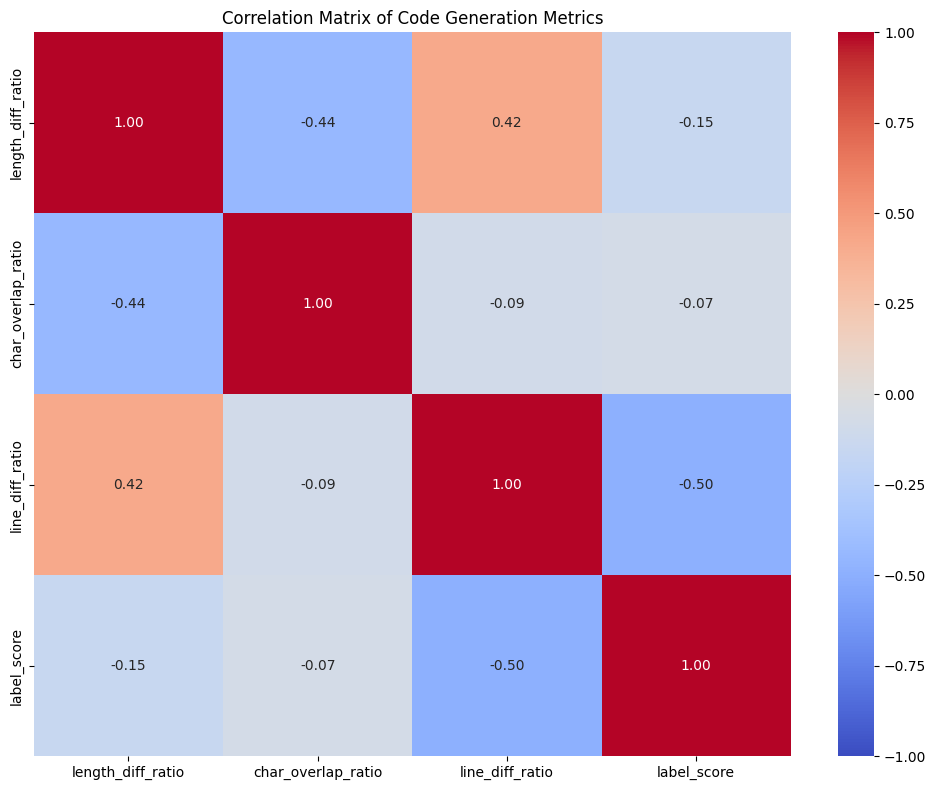


Correlation with Label Score:
length_diff_ratio: -0.155
char_overlap_ratio: -0.071
line_diff_ratio: -0.496


In [5]:
labels_df = pd.read_csv('data/labels/labels.csv')
generation_df = pd.read_excel('data/processed/generation.xlsx')

# Create numeric features
def calculate_metrics(row):
    reference = str(row['middle'])
    generated = str(row['generated code'])
    
    # Length difference ratio
    length_diff = abs(len(reference) - len(generated)) / max(len(reference), 1)
    
    # Character overlap ratio
    char_overlap = len(set(reference) & set(generated)) / len(set(reference) | set(generated)) if reference and generated else 0
    
    # Line count difference
    ref_lines = len(reference.splitlines())
    gen_lines = len(generated.splitlines())
    line_diff = abs(ref_lines - gen_lines) / max(ref_lines, 1)
    
    return pd.Series({
        'length_diff_ratio': length_diff,
        'char_overlap_ratio': char_overlap,
        'line_diff_ratio': line_diff
    })

# Merge metrics with labels
metric_columns = generation_df.apply(calculate_metrics, axis=1)
merged_df = generation_df.join(metric_columns)

label_mapping = {"perfect": 3, "high": 2, "low": 1, "fail": 0}
merged_df['label_score'] = labels_df['label'].map(label_mapping)

# Select numerical columns for correlation
numeric_cols = ['length_diff_ratio', 'char_overlap_ratio', 'line_diff_ratio', 'label_score']
correlation_data = merged_df[numeric_cols]

# Create correlation matrix visualization
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_data.corr(), 
            annot=True,
            cmap='coolwarm',
            vmin=-1, 
            vmax=1,
            center=0,
            fmt='.2f')
plt.title('Correlation Matrix of Code Generation Metrics')
plt.tight_layout()
plt.show()

# Print correlation statistics
print("\nCorrelation with Label Score:")
for col in numeric_cols[:-1]:
    corr = correlation_data[col].corr(correlation_data['label_score'])
    print(f"{col}: {corr:.3f}")

## Distribution of Generated Labels

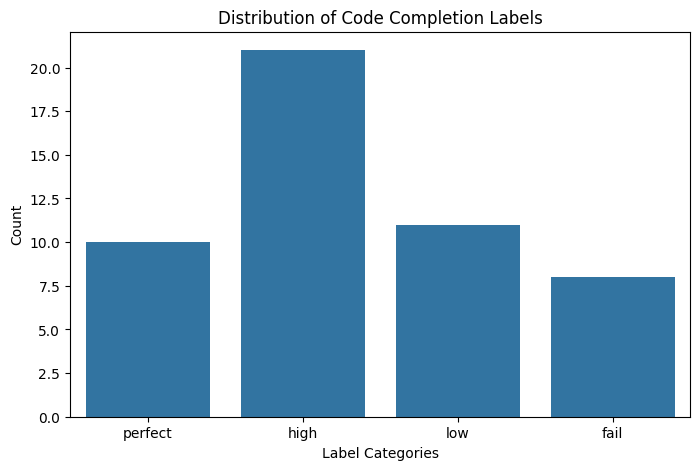

In [6]:
# Plot label distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=labels_df["label"], order=["perfect", "high", "low", "fail"])
plt.title("Distribution of Code Completion Labels")
plt.xlabel("Label Categories")
plt.ylabel("Count")
plt.show()